In [3]:
import pandas as pd
import json
import os
import re

In [6]:
df = pd.DataFrame([], columns=['book_id', 'hierarchy', 'language', 'nr_pages', 'word_count'])

path = './transcripts/no_doubles/'

for filename in os.listdir(path):
    book = json.load(open(path + filename))
    data = {'book_id': filename.replace('.json', ''),
            'hierarchy': book['hierarchy'],
            'language': book['language'],
            'nr_pages': len(book['pages'])}
    
    
    # get the word count per book:
    data['word_count'] = 0
    for page in book['pages']:
        # if there are multiple transcriptions, we don't know which one to use
        if len(page) > 1:
            print('MULTIPLE TRANSCRIPTIONS FOUND: ' + filename)
            break
        else:
            p = page[0]
            for sentence in p:
                # remove all non-alphabetic characters
                data['word_count'] += len(re.sub('[^a-zA-Z ]+', '', sentence).split())

    data=pd.DataFrame(data, index=[0])
    df = pd.concat([df, data], axis=0, ignore_index=True)
        


In [7]:
# For word count: find min, max, average and standard deviation:
print('Minimum word count: ' + str(df['word_count'].min()))
print('Maximum word count: ' + str(df['word_count'].max()))
print('Average word count: ' + str(round(df['word_count'].mean(), 2)))
print('Standard deviation of word count: ' + str(round(df['word_count'].std(), 2)))

# For number of pages: find min, max, average and standard deviation:
print('Minimum number of pages: ' + str(df['nr_pages'].min()))
print('Maximum number of pages: ' + str(df['nr_pages'].max()))
print('Average number of pages: ' + str(round(df['nr_pages'].mean(), 2)))
print('Standard deviation of number of pages: ' + str(round(df['nr_pages'].std(), 2)))

Minimum word count: 2103
Maximum word count: 3335171
Average word count: 466964.44
Standard deviation of word count: 450411.14
Minimum number of pages: 102
Maximum number of pages: 1250
Average number of pages: 383.86
Standard deviation of number of pages: 193.15


In [8]:
df.groupby('language').count()['book_id'].sort_values(ascending=False)

language
eng        37
fra        16
deu        11
ita_old    10
lat         2
Unknown     1
dutch       1
Name: book_id, dtype: int64

In [11]:
import plotly.express as px

fig=px.bar(x=['English', 'Français','German', 'Old Italian', 'Latin', 'Unknown', 'Dutch'],
           y=df.groupby('language')['book_id'].count().sort_values(ascending=False).div(df['book_id'].count()), orientation='v',
           labels={'y': 'Percentage', 'x':'Language of document'},
           title='Percentage of transcribed guidebooks by language')
fig.show()


Almost half of the books we have are written in English, followed by French, German and Italian. Interestingly enough, two are in latin, one in Dutch and one in a language that could not be identified.

In [14]:
holdings = pd.read_csv("./holdings.csv", sep='|', error_bad_lines=False)
export_travel = pd.read_csv('./export_Travel.csv',sep=';',encoding= 'unicode_escape',error_bad_lines=False)

# transform the filename
holdings['filename'] = holdings['filename'].str.replace('-','').str.lower()

#clean date column
holdings.rename(columns={'date;;;;;;;;;;;;;;;;;;;': 'date'}, inplace=True)
holdings.date = holdings.date.str.replace(';','')


#Join the two on filename
travel_books = export_travel.merge(holdings, on=['filename','author','title'])

#Filter for documents that are transcribed
#DocId are the Ids on transkribus, hence, if they are missing, the document has not been transcribed
travel_books = travel_books[travel_books['DocId'].notna()]

#Export docIds for the rest API data gathering
travel_books['DocId'].astype(int).to_csv('DocId.csv', index=False)

C:\Users\zoeje\AppData\Local\Temp/ipykernel_18884/1894332499.py:1: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.



Skipping line 20097: expected 27 fields, saw 209
Skipping line 20761: expected 27 fields, saw 28

C:\Users\zoeje\AppData\Local\Temp/ipykernel_18884/1894332499.py:2: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.





In [15]:
travel_books['DocId'].is_unique

False

In [16]:
travel_books.drop_duplicates(subset=['DocId', 'title'], inplace=True)
df.book_id=df.book_id.astype(int)
travel_df=df.merge(travel_books, how='inner', right_on='DocId', left_on='book_id')
travel_df.drop(['parentId','DocId', 'manifest', 'date', 'year_y', 'standardizedTitle', 'parentTitle', 'format',
                'missing', 'sketchfab', 'lupa', 'rara', 'acquired', 'dlib', 'shelf', 'comment', 'notes'], axis=1, inplace=True)
travel_df.rename(columns={'year_x':'year'}, inplace=True)

In [17]:
travel_df.columns


Index(['book_id', 'hierarchy', 'language', 'nr_pages', 'word_count', 'title',
       'author', 'year', 'opac', 'filename', 'transkribus', 'id', 'subtitle',
       'statement', 'edition', 'volume', 'place', 'publisher', 'contents',
       'illustrations'],
      dtype='object')

In [18]:
travel_df.isnull().sum()

book_id           0
hierarchy         0
language          0
nr_pages          0
word_count        0
title             0
author            2
year              2
opac              0
filename          0
transkribus       0
id                0
subtitle         41
statement        20
edition          67
volume           41
place             5
publisher        11
contents         20
illustrations    46
dtype: int64

We see that two authors are missing, as well as 5 locations. Although a lot of editions and volumes are missing, we keep the ones that are left just in case we need it as additional information, for instance for books published a second time.
Otherwise all titles, book_id, language (although one classified as 'Unknown') are known, and we can find all transcribed books on Transkribus, which is rather good news.

In [19]:
travel_df['place']=travel_df['place'].replace(['Frankfurt a. M.', 'Frankfurt am Main', 'Fanckfurt am Mayn'], 'Frankfurt')
travel_df['place']=travel_df['place'].replace(['Edinburgh [u.a.]', 'New York [u.a.]', '[Europa]'], ['Edinburgh', 'New York', 'Europe'])

In [20]:
import plotly.express as px

fig=px.bar(travel_df.groupby('place').count()['book_id'].sort_values(), orientation='v',
           labels={'value': 'Number of books', 'variable': 'Count', 'place': 'Location of publication'}, 
           title='Publication location counts')
fig.show()

We see that most books have been published in London, then Paris, which is in accordance with the fact that English is the most common language the guidebooks have been written in, followed by French.

In [53]:
travel_df.groupby('author').count().book_id.sort_values(ascending=False)
traveldict=travel_df.groupby('place')['book_id'].unique().to_dict()
data={k : {'books_id' : v.tolist(), 'frequency' : len(v.tolist())} for k,v in traveldict.items()}


with open("../website/src/data/publilocations.json", "w") as f:
    json.dump(data, f, indent=4)

We observe that some authors have published more than one guidebook, but they are few.

In [22]:
fig=px.density_heatmap(x=travel_df['place'], y=travel_df['language'], range_color=[0,8], color_continuous_scale='viridis',
                       labels={'y': 'Language spoken', 'x': 'Location'},
                       title='Language of the guidebooks  vs where they where published')
fig.show()

The location of the guidebooks coincides well with the language in which they were published. There seems to be no location for Dutch, but this can be explained by the fact that some of the books have an unknown publication location.

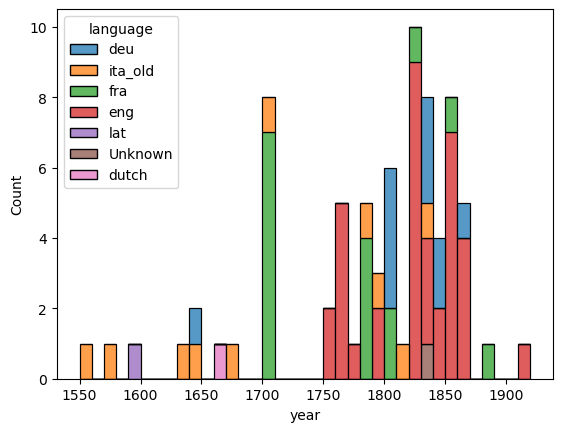

In [23]:
import seaborn as sns
ax= sns.histplot(data=travel_df, x="year", bins='auto', binwidth=10, hue='language', multiple='stack')

The books have been written between 1550 and 1911. We have more books in the period between 1750 and 1870 and it is only from this period that the transcribed books are in English. There are mainly French authors around 1700-1710. The German books, as though fewer than the English ones, were also written around 1800-1870. 

In [24]:
unknown_book=travel_df[travel_df['language']=='Unknown']
unknown_book['book_id']

29    856828
Name: book_id, dtype: int32

In [25]:
url='https://transkribus.humanitiesconnect.pub/#/documents/856828'

As we can observe by clicking on the link above, the mysterious book  whose language Transkribus could not identify is actually written in French in a really bad handwriting that personally, we could barely identify, let alone read it. 
For all the other books, their language has been manually checked.